<a href="https://colab.research.google.com/github/szhang12345/MSDS-422-Assignment-3---Evaluating-Classification-Models/blob/main/Assignment3_Evaluating_Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MSDS 422 Assignment 3: Evaluating Classification Models**

**By Siying Zhang**

**Topic: Bank Marketing Study**

# Ingest

In [101]:
# import base packages into the namespace for this program
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1
from math import sqrt  # for root mean-squared error calculation
#classification models to evaluate
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
# cross-validation scoring
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib import pylab
%matplotlib notebook
%matplotlib inline
pylab.rcParams['figure.figsize'] = (3, 3)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)



from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

# read data for the Bank Marketing Study
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/szhang12345/MSDS-422-Assignment-3---Evaluating-Classification-Models/main"
DATA_PATH = "Datasets"
DATA_FILE = "bank.csv"
FILE_URL = "{}/{}/{}".format(DOWNLOAD_ROOT, DATA_PATH, DATA_FILE)

# Where to save the figures
PROJECT_ROOT_DIR = "./images/"
bank = pd.read_csv(FILE_URL,sep = ';')

# EDA

In [62]:
# examine the shape of original input data
print(bank.shape)

# drop observations with missing data, if any
bank.dropna()
# examine the shape of input data after dropping missing data
print(bank.shape)

# look at the list of column names, note that y is the response
list(bank.columns.values)

# look at the beginning of the DataFrame
bank.head()

# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

# define binary variable for having credit in default
default = bank['default'].map(convert_to_binary)

# define binary variable for having a mortgage or housing loan
housing = bank['housing'].map(convert_to_binary)

# define binary variable for having a personal loan
loan = bank['loan'].map(convert_to_binary)

# define response variable to use in the model
response = bank['response'].map(convert_to_binary)

# gather three explanatory variables and response into a numpy array 
# here we use .T to obtain the transpose for the structure we want
model_data = np.array([np.array(default), np.array(housing), np.array(loan), 
    np.array(response)]).T

# examine the shape of model_data, which we will use in subsequent modeling
print(model_data.shape)

# the rest of the program should set up the modeling methods
# and evaluation within a cross-validation design

(4521, 17)
(4521, 17)
(4521, 4)


In [63]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


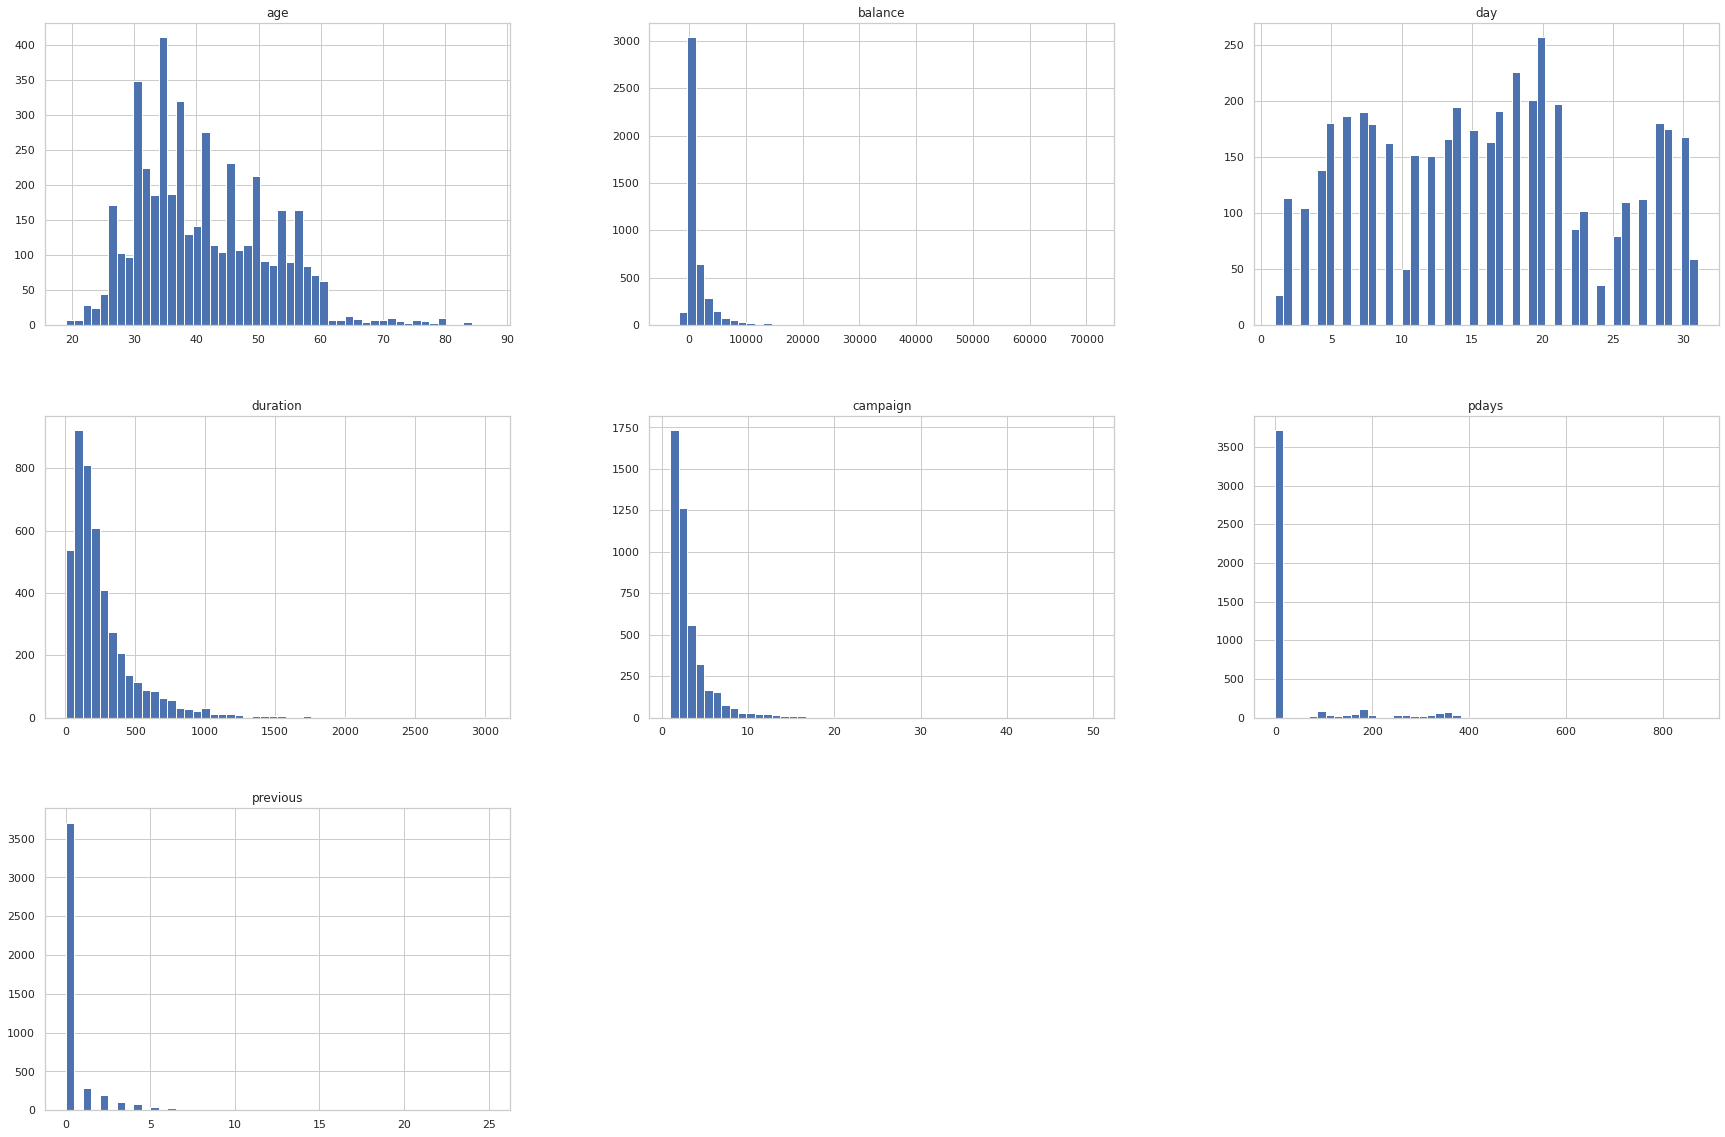

In [64]:
#distribution of continuous variables
bank.hist( bins = 50, figsize = (30, 20)); plt.show()

Binary Explanatory Variables vs Response

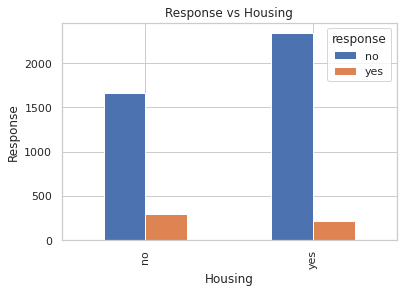

In [65]:
%matplotlib inline
pd.crosstab(bank.housing,bank.response).plot(kind='bar')
plt.title('Response vs Housing')
plt.xlabel('Housing')
plt.ylabel('Response')
plt.savefig('Response vs Housing')



In [66]:
house_response = pd.crosstab(index=bank["housing"], 
                            columns=bank["response"],
                             margins=True)   # Include row and column totals

house_response.columns = ["negative response","positive response","rowtotal"]
house_response.index= ["no house loan","have house loan","coltotal"]
house_response
house_response/house_response.loc['coltotal',"rowtotal"]

,negative response,positive response,rowtotal
no house loan,0.367397,0.066578,0.433975
have house loan,0.517363,0.048662,0.566025
coltotal,0.884760,0.115240,1.000000


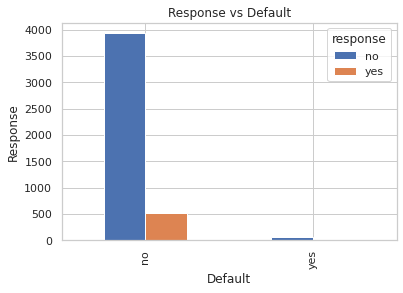

In [67]:
%matplotlib inline
pd.crosstab(bank.default,bank.response).plot(kind='bar')
plt.title('Response vs Default')
plt.xlabel('Default')
plt.ylabel('Response')
plt.savefig('Response vs Default')

In [68]:
default_response = pd.crosstab(index=bank["default"], 
                            columns=bank["response"],
                             margins=True)   # Include row and column totals

default_response.columns = ["negative response","positive response","rowtotal"]
default_response.index= ["no default record","have default record","coltotal"]
default_response
default_response/default_response.loc['coltotal',"rowtotal"]

,negative response,positive response,rowtotal
no default record,0.86994,0.113249,0.98319
have default record,0.01482,0.001991,0.01681
coltotal,0.88476,0.115240,1.00000


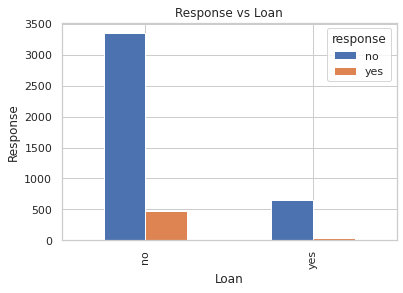

In [69]:
%matplotlib inline
pd.crosstab(bank.loan,bank.response).plot(kind='bar')
plt.title('Response vs Loan')
plt.xlabel('Loan')
plt.ylabel('Response')
plt.savefig('Response vs Loan')


In [70]:
loan_response = pd.crosstab(index=bank["loan"], 
                            columns=bank["response"],
                             margins=True)   # Include row and column totals

loan_response.columns = ["negative response","positive response","rowtotal"]
loan_response.index= ["no personal loan","have personal loan","coltotal"]
loan_response
loan_response/loan_response.loc['coltotal',"rowtotal"]


,negative response,positive response,rowtotal
no personal loan,0.741429,0.105729,0.847158
have personal loan,0.143331,0.009511,0.152842
coltotal,0.884760,0.115240,1.000000


# Modeling

In [102]:
# specify the set of classifiers being evaluated, Bernoulli Naive_Bayes is used given the binary nature of explanatory and response variables
names = ["Naive_Bayes", "Logistic_Regression"]
classifiers = [BernoulliNB(alpha=1.0, binarize=0.5, 
                           class_prior = [0.5, 0.5], fit_prior=False), 
               LogisticRegression()]

# KFold Cross Validation

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



Fold index: 0 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4068, 3)
X_test: (453, 3)
y_train: (4068,)
y_test: (453,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.5878522062732588


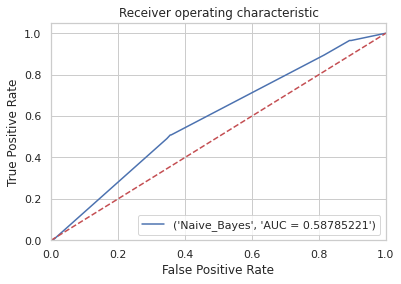


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.5878522062732588


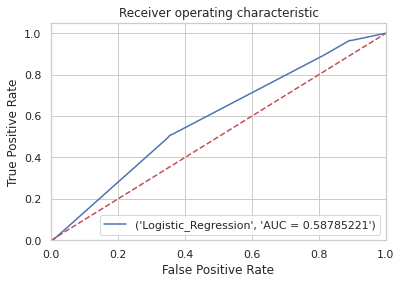


Fold index: 1 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.633727778967659


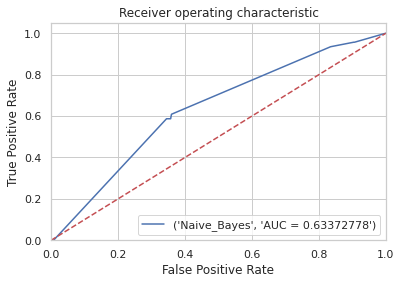


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.633727778967659


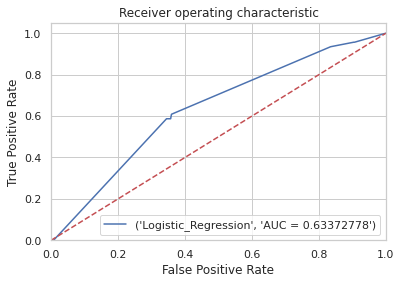


Fold index: 2 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.6575354454752319


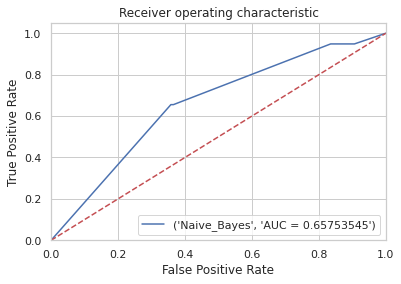


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.6575354454752319


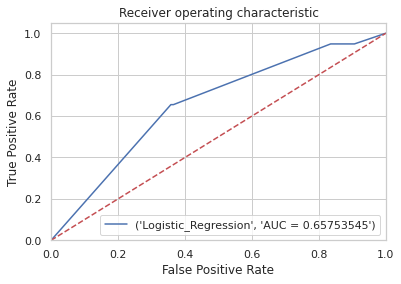


Fold index: 3 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.6373879576644552


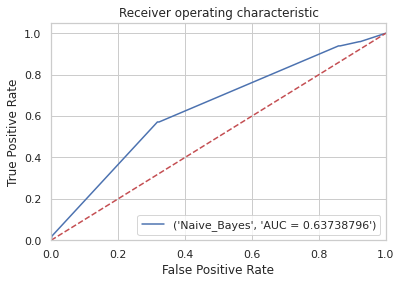


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.6355648959335594


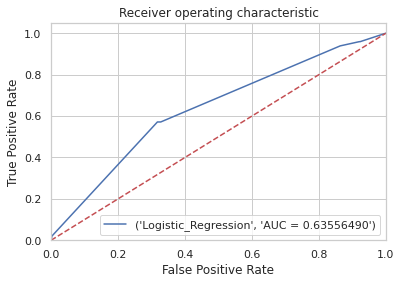


Fold index: 4 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.5743993962517295


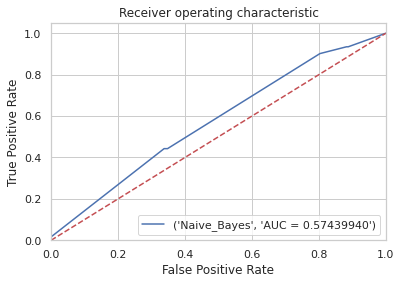


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.5743993962517295


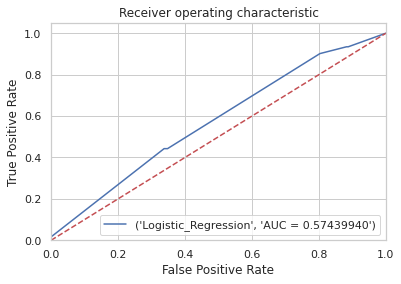


Fold index: 5 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.5746839950151327


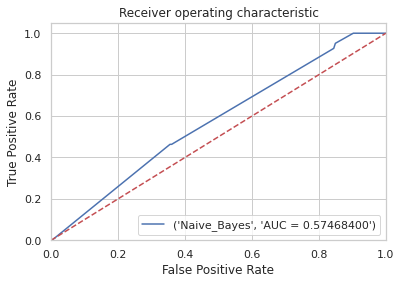


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.5842383241350662


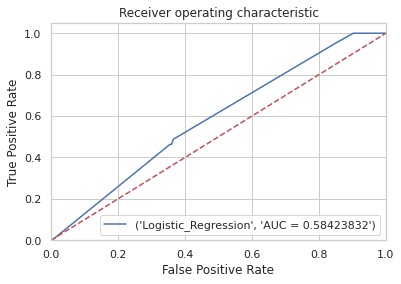


Fold index: 6 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.5625116322352502


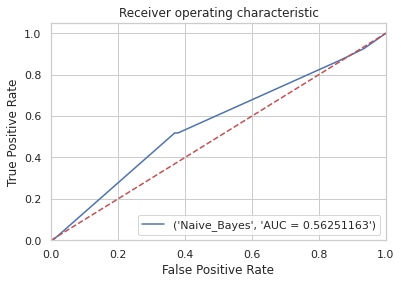


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.5625116322352502


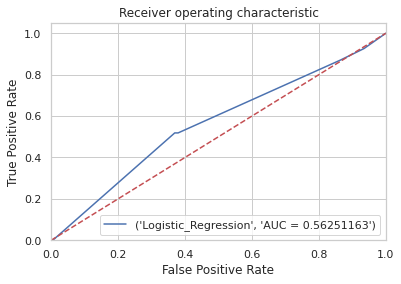


Fold index: 7 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.7311441622103387


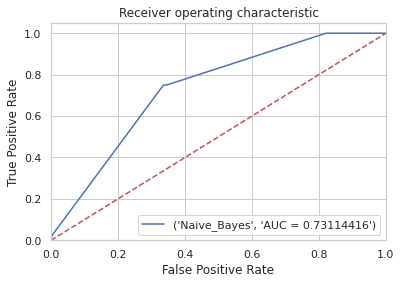


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.7311441622103387


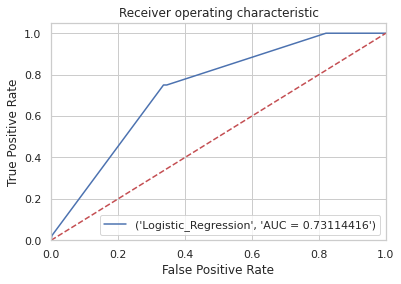


Fold index: 8 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.5735328888258382


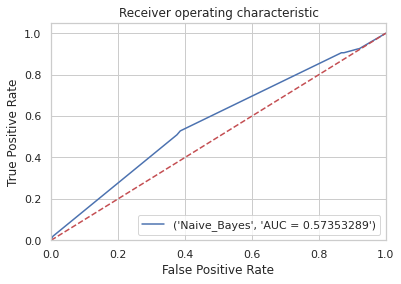


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.5735328888258382


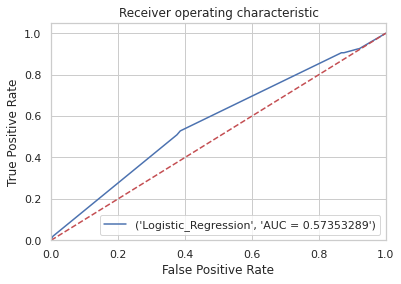


Fold index: 9 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.5778268860493612


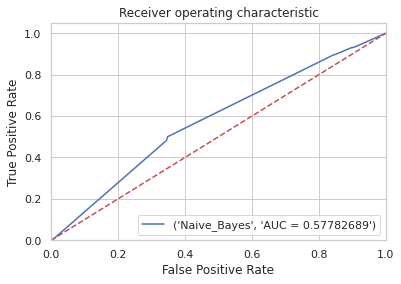


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.5768204095921582


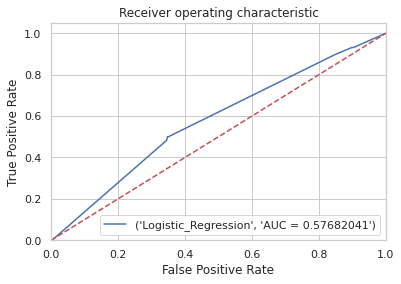


----------------------------------------------
Average results from 10-fold cross-validation

Method                 Area under ROC Curve
Naive_Bayes            0.611060
Logistic_Regression    0.611733
dtype: float64
Naive_Bayes            0.053606
Logistic_Regression    0.052946
dtype: float64


In [73]:
# ten-fold cross-validation
K = 10

# set up numpy array for storing results
cv_results = np.zeros((K, len(names)))

kf = KFold(n_splits = K, shuffle=False, random_state = RANDOM_SEED)
# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized 
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')
#   note that 0:model_data.shape[1]-1 slices for explanatory variables
#   and model_data.shape[1]-1 is the index for the response variable    
    X_train = model_data[train_index, 0:model_data.shape[1]-1]
    X_test = model_data[test_index, 0:model_data.shape[1]-1]
    y_train = model_data[train_index, model_data.shape[1]-1]
    y_test = model_data[test_index, model_data.shape[1]-1]   
    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)

    index_for_method = 0  # initialize
    for name, clf in zip(names, classifiers):
        print('\nClassifier evaluation for:', name)
        print('  Scikit Learn method:', clf)
        clf.fit(X_train, y_train)  # fit on the train set for this fold
        # evaluate on the test set for this fold
        y_test_predict = clf.predict_proba(X_test)
        fold_method_result = roc_auc_score(y_test, y_test_predict[:,1]) 
        print('Area under ROC curve:', fold_method_result)
        cv_results[index_for_fold, index_for_method] = fold_method_result
        #create ROC curve to visualize model prediction performance with different threshold
        roc_auc = roc_auc_score(y_test, y_test_predict[:,1])
        fpr, tpr, thresholds = roc_curve(y_test, y_test_predict[:,1])
        plt.figure()
        plt.plot(fpr, tpr, label=(name, 'AUC = %0.8f' % roc_auc))
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig('AUC_ROC')
        plt.show()
        index_for_method += 1
  
    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n----------------------------------------------')
print('Average results from ', K, '-fold cross-validation\n',
      '\nMethod                 Area under ROC Curve', sep = '')     
print(cv_results_df.mean()) 
print(cv_results_df.std())

# GridSearch Cross Validation

In [103]:
df=pd.DataFrame(model_data,columns=['default','housing', 'loan','response'])
features=df.drop(['response'],axis=1)
labels=df.response

In [104]:

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1, stratify = labels)
kf = StratifiedKFold(n_splits = K, shuffle=False, random_state = RANDOM_SEED)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [113]:
# DataFrame to store results
testing = pd.DataFrame(columns = ["Classifier", "F1-Score", "AUC", "Accuracy"])

Logistic Regression

In [114]:
params = [
            {
                "penalty" : ['l2'], 
                "C" : [0.01, 0.1, 1.0, 10.0,100.0], 
                "solver" : ["sag"], 
                "max_iter" : [100,500,1000]
            },
            {
                "penalty" : ['l1'], 
                "C" : [0.01, 0.1, 1.0, 10.0], 
                "solver" : ["saga"], 
                "max_iter" : [100,500,1000]
            }
]
clf = GridSearchCV(estimator = LogisticRegression(n_jobs = -1, class_weight = "balanced"), param_grid = params, cv = kf, 
                   n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                          'max_iter': [100, 500, 1000], 'penalty': ['l2'],
                          'solver': ['sag']},
                         {'C': [0.01, 0.1, 1.0, 10.0],
                          'max_iter': [10

In [115]:
clf.best_params_

{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}

In [116]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Logistic Regression", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.268
Area under ROC on test data is : 0.611
Accuracy on test data is : 0.644


Naive Bayes

In [117]:
params = {}
clf = GridSearchCV(estimator = GaussianNB(), param_grid = params, cv = kf, n_jobs = -1, scoring = "f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=False),
             error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=-1, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [118]:
f1 = f1_score(y_test, clf.predict(X_test))
auc = roc_auc_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print("F1-Score on test data is : %0.3f" %f1)
print("Area under ROC on test data is : %0.3f" %auc)
print("Accuracy on test data is : %0.3f" %acc)

testing.loc[-1] = ["Gaussian Naive Bayes", f1, auc, acc]
testing.index = testing.index + 1
testing = testing.sort_index()

F1-Score on test data is : 0.019
Area under ROC on test data is : 0.504
Accuracy on test data is : 0.884


In [119]:
testing

,Classifier,F1-Score,AUC,Accuracy
0,Gaussian Naive Bayes,0.018692,0.503559,0.883978
1,Logistic Regression,0.268182,0.610745,0.644199


# Conclusion

**BACKGROUND**

Telephone marketing campaigns can provide methods to reach out to customers and introduce products of bank to them. A good machine learning method that provides telephone marketing campaigns with proper guidance will help the bank more efficiently target the customers that have high lifetime value and are more likely to participate in the promoted products, consequently, the bank can benefit from receiving high return on investment. In this research, we use classification models to help determine the targeted customers and evaluate the performance of different classification models.

**RESEARCH DESIGN AND MODELING METHODS**

The data set provided has 4521 rows of data. Each row is a customer record that includes 17 variables specific to the client’s demographics, their assets with the bank, when and how they were contacted, how frequently they were contacted and if they purchased a term deposit. The data is a mix of categorical variables, continuous variables and binary variables. Model data consists of three binary explanatory variables: default, housing, and loan and one response variable: response. All banking client observations with complete data for these study variables are used in the research. Though continuous variables are not main focus of this research, we also presented the distribution of those variables to have an overall understanding of the data on hands. It appeared that most continuous variables have skewed distributions. We also observed that around 11.5% of all customers are interested in the term deposit offers with a ‘yes’ response. For the three binary explanatory variables, it was observed that more than 98% of clients do not have default records, around 85% of clients do not have personal loans, which indicate that both ‘default’ and ‘loan’ variables have imbalanced class distribution. On the other hand, ‘housing’ variable is relatively balanced with around 43% of clients don’t have housing loans while around 57% of clients do. For the purpose of providing machine learning models that help predict the binary response variable: Has the client subscribed to a term deposit, two classification methods: (1) logistic regression and (2) naïve Bayes classification were implemented and evaluated.

**TECHNICAL OVERVIEW**

After the exploratory data analysis and transformation of explanatory and response variables from categorical responses to binary: 0 for no, 1 for yes. We created subset data including only these four variables via standard DataFrame slice operations via indexes. For the evaluation of both classification models, K fold cross validation design, where K=10, is implemented. The area under the receiver operating characteristic (ROC) curve is used as an index of classification performance. The ROC curve summarizes the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds and the AUC provides us the accuracy of predictions. All the implementation of modeling is in Python Scikit Learn environment.

**RECOMMENDATIONS**

Under KFOLD Cross Validation design, the mean ROC AUC for the logistic regression model is 0.611733, and the mean for ROC AUC for Naive Bayes model is 0.611060. In addition, the standard deviation is slightly lower for Logistic Regression than Naive Bayes models. Combined this information, it appears that the Logistic Regression model performs slightly better than Naive Bayes model for the prediction of customer responses given the three binary explanatory variables. Under the circumstance where we only have these two options, Logistic Regression model would be a preferred classification model given the outcome of evaluation under 10-Fold cross validation design.

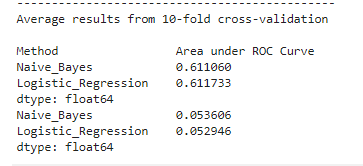


Under GridSearch Cross Validation design, the result is similar, logistic regression has higher area under ROC, but compared with kfold cross validation, the accuracy is lower.

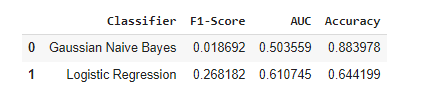

Given the fact that there is a relatively small positive response rate at 11.5% in the dataset, alternative evaluation metrics are recommended to more accurately reflect the performance of both models.  In addition, further analysis of other provided variables is recommended during the modeling design process, given the possibility that other more impactful variables which are not considered in the classification models might result in better prediction performance.
